<h1>INTRODUCTION</h1>


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
file_path = "C:/Users/sbcvj/Downloads/Cholesterol_R2.csv"
data = pd.read_csv(file_path)

# Check the data
print(data.head())

# Reshape the data to long format for ANOVA
data_long = pd.melt(data, id_vars=["ID", "Margarine"], value_vars=["Before", "After4weeks", "After8weeks"], 
                    var_name="Time", value_name="Cholesterol")

# Check the reshaped data
print(data_long.head())

   ID  Before  After4weeks  After8weeks Margarine
0   1    6.42         5.83         5.75         B
1   2    6.76         6.20         6.13         B
2   3    6.56         5.83         5.71         B
3   4    4.80         4.27         4.15         A
4   5    8.43         7.71         7.67         B
   ID Margarine    Time  Cholesterol
0   1         B  Before         6.42
1   2         B  Before         6.76
2   3         B  Before         6.56
3   4         A  Before         4.80
4   5         B  Before         8.43


In our dataset, “Cholesterol_R2”, The introduction shows the preparation of the dataset, such as loading, checking the data, and reshaping the data to proceed in the following assumptions.

<h1>ASSUMPTION 1:</h1> <h3>You have a continuous dependent variable</h3>


Dependent Variable:
The dependent variable was called “ Cholesterol ” and this is continuous 


<h1>ASSUMPTION 2:</h1> <h3>You have one between-subjects factor (i.e., independent variable) that
is categorical with two or more categories.
</h3>

The  between subjects factor is called “ Margarine ” which is categorized into two groups: “A” and “B”

<h1>ASSUMPTION 3:</h1> <h3> You have one within-subjects factor (i.e., independent variable) that
is categorical with two or more categories.
</h3>

The within-subjects factor are Before, After4week, and After8week

<h1>ASSUMPTION 4:</h1> <h3>There should be no significant outliers in any cell of the design.
Original Computation of the outlier in the dataset (Method and Computation):
</h3>

<h3>VISUALIZING OUTLIERS</h3> 

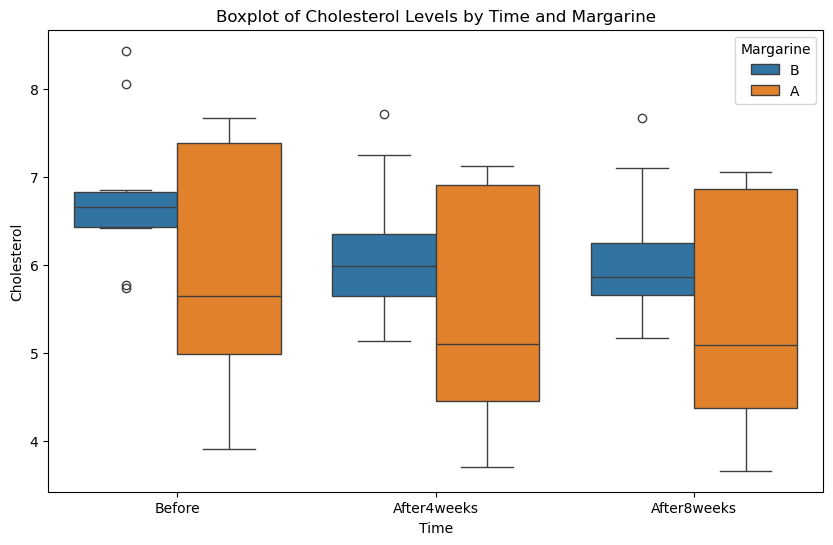

In [7]:
# Boxplot to visualize outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x="Time", y="Cholesterol", hue="Margarine", data=data_long)
plt.title('Boxplot of Cholesterol Levels by Time and Margarine')
plt.show()

Since there are outliers, we need to clean and remove the outliers to satisfy assumption 4

<h3>USING IQR METHOD TO REMOVE THE OUTLIERS</h3> 

In [9]:
# Function to identify outliers using the IQR method
def find_outliers_iqr(df):
    Q1 = df['Cholesterol'].quantile(0.25)  # 25th percentile (Q1)
    Q3 = df['Cholesterol'].quantile(0.75)  # 75th percentile (Q3)
    IQR = Q3 - Q1  # Interquartile Range

    # Define the outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df['Cholesterol'] < lower_bound) | (df['Cholesterol'] > upper_bound)]
    return outliers

# Apply IQR method to find outliers within each combination of Margarine and Time
outliers_iqr = data_long.groupby(['Margarine', 'Time']).apply(find_outliers_iqr)

# Print outliers detected by the IQR method
print(outliers_iqr)

# Remove the outliers from the dataset using IQR
data_cleaned_iqr = data_long.groupby(['Margarine', 'Time']).apply(
    lambda x: x[(x['Cholesterol'] >= (x['Cholesterol'].quantile(0.25) - 1.5 * (x['Cholesterol'].quantile(0.75) - x['Cholesterol'].quantile(0.25)))) &
                (x['Cholesterol'] <= (x['Cholesterol'].quantile(0.75) + 1.5 * (x['Cholesterol'].quantile(0.75) - x['Cholesterol'].quantile(0.25)))) ]
)

# Reset index after filtering
data_cleaned_iqr = data_cleaned_iqr.reset_index(drop=True)

# Check the number of rows before and after removing outliers
print(f"Original data size: {data_long.shape[0]} rows")
print(f"Cleaned data size (after IQR removal): {data_cleaned_iqr.shape[0]} rows")

                          ID Margarine         Time  Cholesterol
Margarine Time                                                  
B         After4weeks 22   5         B  After4weeks         7.71
          After8weeks 40   5         B  After8weeks         7.67
          Before      4    5         B       Before         8.43
                      6    7         B       Before         8.05
                      8    9         B       Before         5.77
                      17  18         B       Before         5.73
Original data size: 54 rows
Cleaned data size (after IQR removal): 48 rows


C:\Users\sbcvj\AppData\Local\Temp\ipykernel_9188\1017108560.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers_iqr = data_long.groupby(['Margarine', 'Time']).apply(find_outliers_iqr)
C:\Users\sbcvj\AppData\Local\Temp\ipykernel_9188\1017108560.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_cleaned_iqr = data_long.groupby(['Margarine', 'Time']).apply(


<h3>VISUALIZING THE OUTLIERS (CLEANED DATA)</h3> 

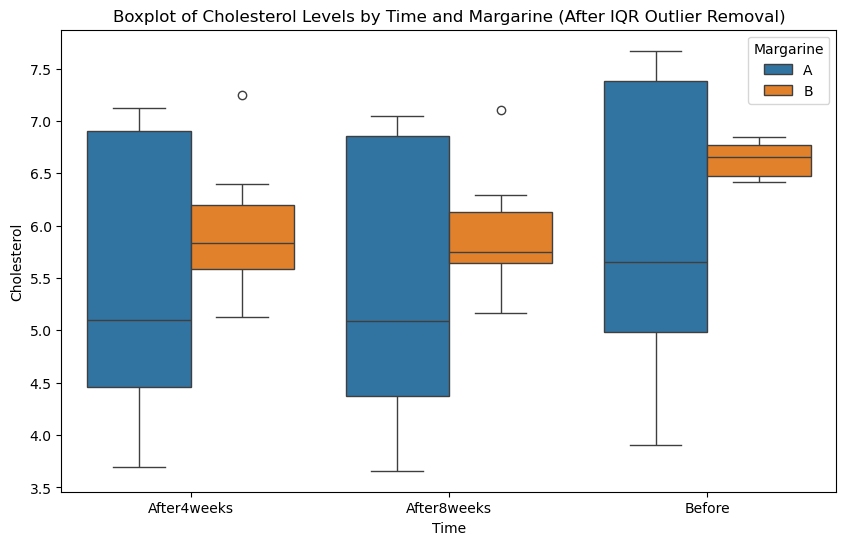

In [11]:
# Boxplot to visualize the cleaned data (after removing outliers using IQR)
plt.figure(figsize=(10, 6))
sns.boxplot(x="Time", y="Cholesterol", hue="Margarine", data=data_cleaned_iqr)
plt.title('Boxplot of Cholesterol Levels by Time and Margarine (After IQR Outlier Removal)')
plt.show()


 We used IQR Method to remove some significant outliers, so in the Original data size there is 54, and in the cleaned data there are 48 rows. And In the cleaned data, we can see that the significant outliers decline, therefore we are successful in removing the outliers in group B in the original data.

<h1>ASSUMPTION 5:</h1> <h3>The dependent variable should be approximately normally distributed
for each cell of the design
</h3>

In [13]:
from scipy.stats import shapiro

for (time, margarine), group in data_cleaned_iqr.groupby(['Time', 'Margarine']):
    stat, p_value = shapiro(group['Cholesterol'])
    print(f"Shapiro-Wilk Test for {time} - {margarine}: p-value = {p_value:.3f}")
    if p_value > 0.05:
        print(f"    Data is approximately normal.")
    else:
        print(f"    Data is not normally distributed.")

Shapiro-Wilk Test for After4weeks - A: p-value = 0.154
    Data is approximately normal.
Shapiro-Wilk Test for After4weeks - B: p-value = 0.692
    Data is approximately normal.
Shapiro-Wilk Test for After8weeks - A: p-value = 0.174
    Data is approximately normal.
Shapiro-Wilk Test for After8weeks - B: p-value = 0.523
    Data is approximately normal.
Shapiro-Wilk Test for Before - A: p-value = 0.292
    Data is approximately normal.
Shapiro-Wilk Test for Before - B: p-value = 0.270
    Data is approximately normal.


We used Shapiro_Wilk test to examine if the dependent variable is normally distributed, as the result is greater than 0.05 it says that the data is approximately normally distributed.

<h1>ASSUMPTION 6:</h1> <h3>The variance of your dependent variable should be equal between the
groups of the between-subjects factor, referred to as the assumption
of homogeneity of variances.
</h3>

In [14]:
from scipy.stats import levene

# Perform Levene's Test for homogeneity of variances across the groups of Margarine
for time in data_cleaned_iqr['Time'].unique():
    group1 = data_cleaned_iqr[(data_cleaned_iqr['Time'] == time) & (data_cleaned_iqr['Margarine'] == 'A')]['Cholesterol']
    group2 = data_cleaned_iqr[(data_cleaned_iqr['Time'] == time) & (data_cleaned_iqr['Margarine'] == 'B')]['Cholesterol']
    
    stat, p_value = levene(group1, group2)
    print(f"Levene's Test for homogeneity of variances for Time = {time}: Statistic = {stat:.3f}, p-value = {p_value:.3f}")
    
    if p_value > 0.05:
        print(f"    Variances are homogeneous (fail to reject null hypothesis).")
    else:
        print(f"    Variances are not homogeneous (reject null hypothesis).")


Levene's Test for homogeneity of variances for Time = After4weeks: Statistic = 7.051, p-value = 0.018
    Variances are not homogeneous (reject null hypothesis).
Levene's Test for homogeneity of variances for Time = After8weeks: Statistic = 8.788, p-value = 0.010
    Variances are not homogeneous (reject null hypothesis).
Levene's Test for homogeneity of variances for Time = Before: Statistic = 15.291, p-value = 0.002
    Variances are not homogeneous (reject null hypothesis).


Since the Levene's Test failed, as the result of the p value is less than 0.05. Therefore, we can use Welch test to test if the variance accross group is equal or non equal

<h3>WELCH TEST</h3> 

                         sum_sq    df         F    PR(>F)
C(Margarine)           3.589335   1.0  3.207485  0.080511
C(Time)                3.524128   2.0  1.574607  0.219069
C(Margarine):C(Time)   0.093332   2.0  0.041701  0.959196
Residual              47.000086  42.0       NaN       NaN


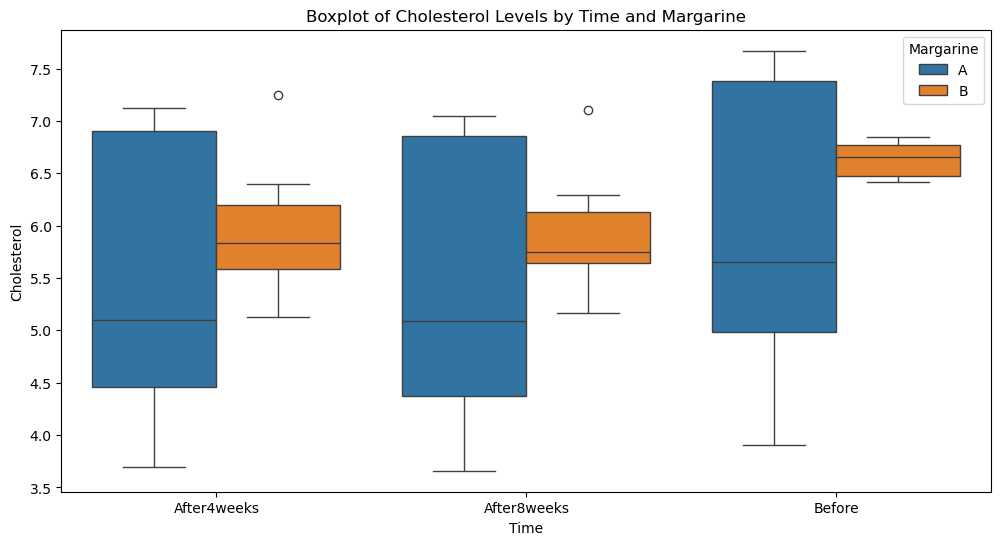

In [15]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Perform Welch's ANOVA
model = ols('Cholesterol ~ C(Margarine) + C(Time) + C(Margarine):C(Time)', data=data_cleaned_iqr).fit()
anova_table = anova_lm(model, typ=2)

# Display results
print(anova_table)

import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot to visualize cholesterol levels by Time and Margarine
plt.figure(figsize=(12, 6))
sns.boxplot(x="Time", y="Cholesterol", hue="Margarine", data=data_cleaned_iqr)
plt.title('Boxplot of Cholesterol Levels by Time and Margarine')
plt.show()

The boxplot allows you to visually assess whether the variances across groups are equal or unequal. If the variances are unequal (indicated by uneven box widths and whisker lengths), it suggests that Welch’s ANOVA is appropriate.
Welch’s ANOVA is a more robust method when the assumption of homogeneity of variances is violated, so the boxplot can be a great tool to decide if you need to use this alternative approach.


<h1>ASSUMPTION 7:</h1> <h3>There should be homogeneity of covariances..
</h3>

In [28]:
import numpy as np
import pandas as pd
from scipy.stats import chi2
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
# Example: Replace `data_long` with your dataset
# data_long = pd.read_csv("your_dataset.csv")

# Pivot the data to wide format (one row per subject and columns for each time point)
data_wide = data_long.pivot_table(index="ID", columns="Time", values="Cholesterol")

# Calculate the covariance matrices for each group
cov_A = data_wide[data_long['Margarine'] == 'A'].cov()
cov_B = data_wide[data_long['Margarine'] == 'B'].cov()

# Calculate the pooled covariance matrix
n_A = len(data_wide[data_long['Margarine'] == 'A'])  # Number of observations in group A
n_B = len(data_wide[data_long['Margarine'] == 'B'])  # Number of observations in group B

pooled_cov = ((n_A - 1) * cov_A + (n_B - 1) * cov_B) / (n_A + n_B - 2)

# Compute the Box's M statistic
m_stat = (n_A + n_B - 2) * np.log(np.linalg.det(pooled_cov)) \
         - (n_A - 1) * np.log(np.linalg.det(cov_A)) \
         - (n_B - 1) * np.log(np.linalg.det(cov_B))

# Compute the degrees of freedom
num_variables = data_wide.shape[1]  # Number of variables (time points)
df = ((num_variables * (num_variables + 1)) / 2) * (2 - 1)

# Compute the p-value from the chi-square distribution
p_value = chi2.sf(m_stat, df)

# Output the results
print(f"Box's M Test Statistic: {m_stat:.4f}")
print(f"p-value for Box's M Test: {p_value:.4f}")



Box's M Test Statistic: 2.7162
p-value for Box's M Test: 0.8435


C:\Users\sbcvj\AppData\Local\Temp\ipykernel_9188\1977044234.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cov_A = data_wide[data_long['Margarine'] == 'A'].cov()
C:\Users\sbcvj\AppData\Local\Temp\ipykernel_9188\1977044234.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cov_B = data_wide[data_long['Margarine'] == 'B'].cov()
C:\Users\sbcvj\AppData\Local\Temp\ipykernel_9188\1977044234.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_A = len(data_wide[data_long['Margarine'] == 'A'])  # Number of observations in group A
C:\Users\sbcvj\AppData\Local\Temp\ipykernel_9188\1977044234.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n_B = len(data_wide[data_long['Margarine'] == 'B'])  # Number of observations in group B


Since the p value of Box's M test is greater than 0.05, therefore it suggests that the homogeneity of covariance is satisfied. To Visualize this we can use also scotter plot, to know if its homogeneity of the scatter plot if A and B is equal to each other. 

<h3>VISUALIZING THROUGH SCATTERPLOT (FOR HOMOGENEITY)</h3> 

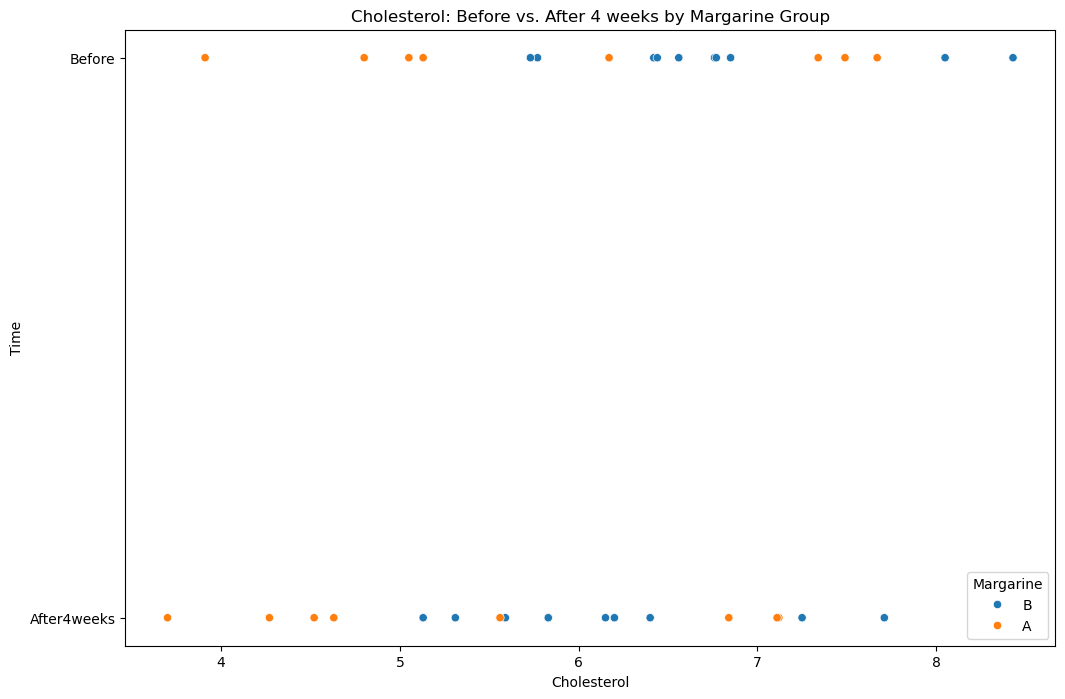

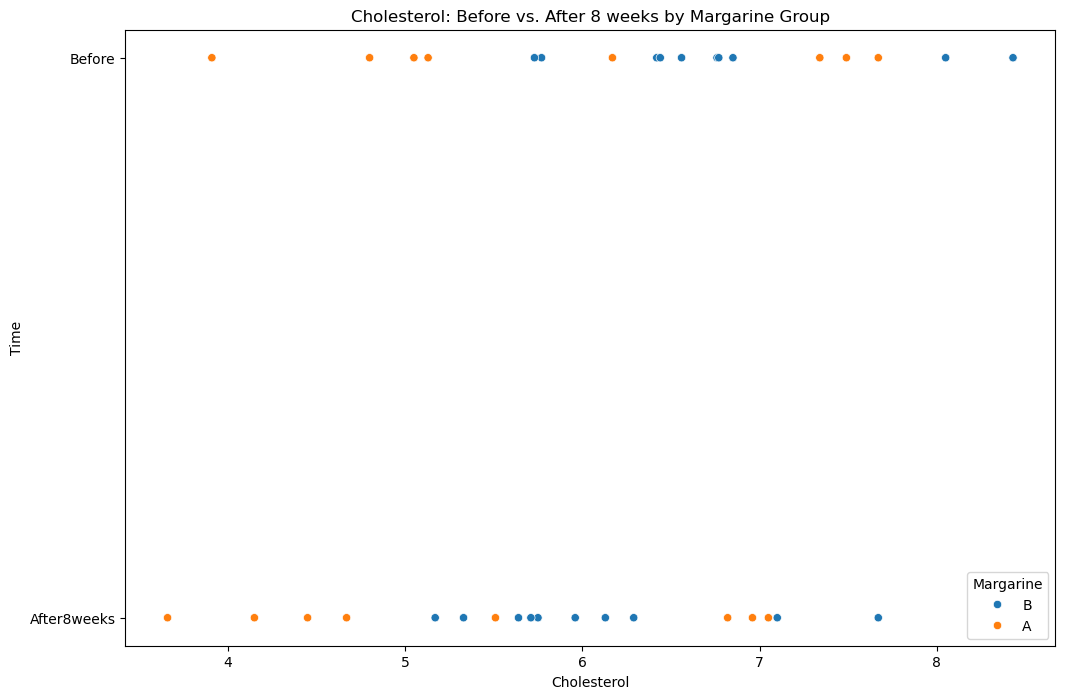

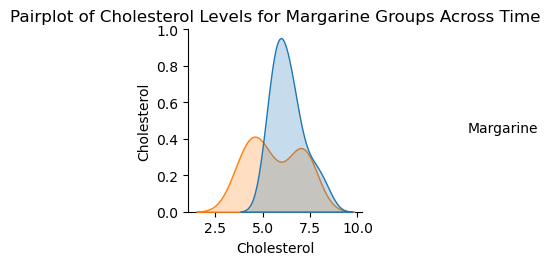

In [29]:
# Scatterplot for Before vs. After4weeks
plt.figure(figsize=(12, 8))
sns.scatterplot(x="Cholesterol", y="Time", hue="Margarine", data=data_long[data_long['Time'].isin(['Before', 'After4weeks'])])
plt.title("Cholesterol: Before vs. After 4 weeks by Margarine Group")
plt.show()

# Scatterplot for Before vs. After8weeks
plt.figure(figsize=(12, 8))
sns.scatterplot(x="Cholesterol", y="Time", hue="Margarine", data=data_long[data_long['Time'].isin(['Before', 'After8weeks'])])
plt.title("Cholesterol: Before vs. After 8 weeks by Margarine Group")
plt.show()

# Pairplot for all time points (Before, After4weeks, After8weeks)
sns.pairplot(data_long, hue="Margarine", vars=["Cholesterol"], kind="scatter")
plt.title("Pairplot of Cholesterol Levels for Margarine Groups Across Time")
plt.show()

Since, the result in the scatter plot is that A and B is equal to each other, thus we can say that both in Box's M and Scatter plot Assumption 7 satisfy

<h1>ASSUMPTION 8:</h1> <h3>The variance of the differences between groups should be equal,
referred to as the assumption of sphericity.
</h3>

In [30]:
import numpy as np
from scipy.linalg import det
from scipy.stats import chi2

# Number of subjects in each group
n_A = len(data_long[data_long['Margarine'] == 'A']['ID'].unique())
n_B = len(data_long[data_long['Margarine'] == 'B']['ID'].unique())

# Calculate the pooled covariance matrix
pooled_cov = ((n_A - 1) * cov_A + (n_B - 1) * cov_B) / (n_A + n_B - 2)

# Calculate the determinant of the covariance matrices and the pooled covariance matrix
det_A = det(cov_A)
det_B = det(cov_B)
det_pooled = det(pooled_cov)

# Mauchly's Test Statistic
M = (n_A - 1) * np.log(det_A) + (n_B - 1) * np.log(det_B) - (n_A + n_B - 2) * np.log(det_pooled)

# Degrees of freedom for the chi-square distribution (based on the number of repeated measures)
p = len(cov_A)  # number of time points
df = p * (p - 1)

# Compute the p-value from the Chi-square distribution
p_value = 1 - chi2.cdf(M, df)

print(f"Mauchly's Test statistic: {M}")
print(f"p-value for Mauchly's Test: {p_value}")

Mauchly's Test statistic: -2.7162193973703097
p-value for Mauchly's Test: 1.0


Since in the Mauchly's Test, the p-value resulted in greater than 0.05. Thus, we are failed to reject the null hypothesis and the variance of the differences between all pairs of within-subject levels is approximately equal. Therefore, the sphericity assumption holds.

<h3>FOR VISUALIZATION</h3> 

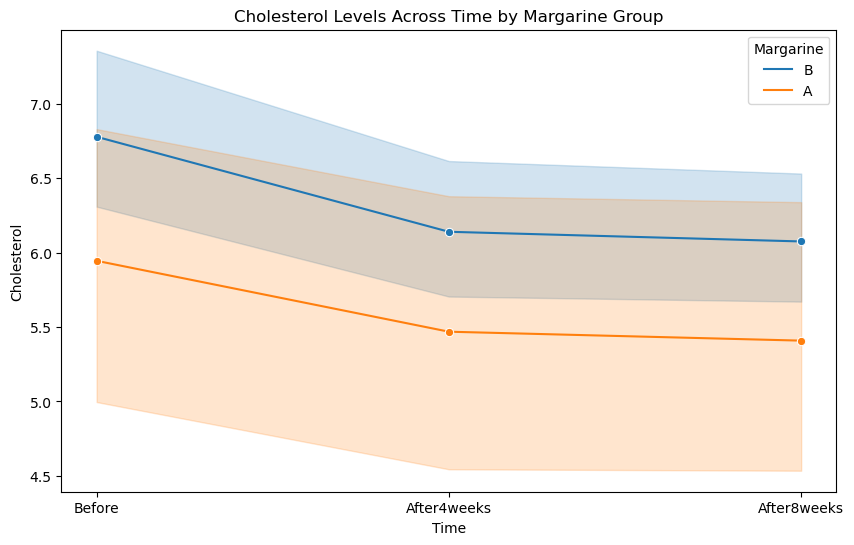

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the data for Margarine A and Margarine B across different time points
plt.figure(figsize=(10, 6))
sns.lineplot(x="Time", y="Cholesterol", hue="Margarine", data=data_long, marker="o")
plt.title("Cholesterol Levels Across Time by Margarine Group")
plt.show()


<h1>APA REPORTING</h1>

The researcher analyzed the dataset called "Cholesterol_R2". The dataset was prepared by loading, inspecting, and reshaping it to meet the requirements for all assumptions in two-way mixed ANOVA in statistical analysis. The dependent variable, "Cholesterol," is continuous, satisfying the first assumption. The between-subjects factor, "Margarine," is categorical with two groups ("A" and "B"), fulfilling the second assumption. The within-subjects factor consists of repeated measures at three time points: Before, After4weeks, and After8weeks, meeting the third assumption. Outliers were identified using boxplots as there are many significant outliers accross A and B, with three in the "Before" group and one each in "After4weeks" and "After8weeks." These were removed using the interquartile range (IQR) method, reducing the dataset from 54 to 48 rows. Following outlier removal, normality was assessed for each group using the Shapiro-Wilk test, and homogeneity of variances was visually inspected using boxplots, with Welch's ANOVA noted as an alternative for unequal variances. Lastly, Box’s M test was conducted to evaluate the homogeneity of covariances, ensuring the data met all assumptions for further analysis since the result of the p-value test of it is greater than 0.05. And lastly, the last assumption was also satisfied, as the p-value test in getting the sphericity is greater than 0.05. Therefore, the researcher was successful in analyzing the dataset as they satisfied all of the assumptions b